In [112]:
%reload_ext autoreload
%autoreload 2

In [116]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [117]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [74]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

### 1) Who are the top and bottom 10  users by 

In [75]:
### Parsing Data
data_directory = os.path.join(rpath, "data")
slack_data_loader = SlackDataLoader(data_directory)
# List all directories in the 'data' directory
directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]


dfs_by_directory = []

# Iterate through each directory
for directory in directories:
    directory_path = os.path.join(data_directory, directory)
    df_directory = slack_data_loader.slack_parser(directory_path)
    
    # Add a 'directory' column to identify the source directory
    df_directory['directory'] = directory
    
    # Append the DataFrame to the list
    dfs_by_directory.append(df_directory)

# Concatenate all DataFrames into a single DataFrame
slack_parser_df = pd.concat(dfs_by_directory, ignore_index=True)
slack_parser_df.head(5)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,directory
0,message,"Hi guys,\nI thought having a group chat would ...",Anita Rodriguez,1661766066.863109,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group
1,message,good!!,Michael Gonzalez,1661766159.852649,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group
2,message,Thanks <@U03U9FWPNCE>,Robert Carter,1661766226.215889,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group
3,message,Nice <@U03U9FWPNCE>,Phillip Atkins,1661766241.597379,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group
4,message,I have been missing deadlines and I am trying ...,Anita Rodriguez,1661766295.939119,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group


#### a) by reply count

In [76]:

# Users grouped by 'sender_name
grouped_by_user = slack_parser_df.groupby('sender_name')['reply_users_count'].sum().reset_index(name='total_reply_count')
# TOP 10 users by reply count
sorted_by_reply_count = grouped_by_user.sort_values(by='total_reply_count', ascending=False)
sorted_by_reply_count.head(10)

,sender_name,total_reply_count
15,Cristian Wilson,311
57,Vanessa Norman,276
42,Michelle Lewis,193
8,Brenda Hernandez,179
9,Brian Odom,171
56,Travis Butler,162
4,April Lucas,153
1,Amy Leon,151
30,Joshua Rhodes,143
49,Phillip Atkins,138


In [77]:
# BOTTOM 10 users by reply count
sorted_by_reply_count = grouped_by_user.sort_values(by='total_reply_count', ascending=True)
sorted_by_reply_count.head(10)

,sender_name,total_reply_count
22,Erica Munoz,0
46,Patricia Thomas,0
6,Blake Scott,0
54,Slackbot,0
47,Patrick Hernandez,0
25,Holly Whitaker,0
17,David Scott,0
14,Christopher Case,0
35,Leah Newton,2
50,Randy Miller,3


#### b) by mentions

In [78]:
mention_count = slack_parser_df['msg_content'].apply(lambda x: len(re.findall(r'@U\w+', x)))
filtered_df = slack_parser_df[slack_parser_df['msg_content'].str.contains('@U', regex=True)]

#TOP 10 users by mentions
top_users_mention_count = mention_count.groupby(slack_parser_df['sender_name']).sum().reset_index(name='total_mention_count').sort_values(by='total_mention_count', ascending=False).head(10)
top_users_mention_count

,sender_name,total_mention_count
57,Vanessa Norman,532
4,April Lucas,214
15,Cristian Wilson,206
7,Brady Rhodes,184
56,Travis Butler,181
1,Amy Leon,158
8,Brenda Hernandez,147
49,Phillip Atkins,139
31,Judith Bolton,130
9,Brian Odom,113


In [79]:
#BOTTOM 10 users by mentions
bottom_users_mention_count = mention_count.groupby(slack_parser_df['sender_name']).sum().reset_index(name='total_mention_count').sort_values(by='total_mention_count', ascending=True).head(10)
bottom_users_mention_count

,sender_name,total_mention_count
57,Vanessa Norman,532
4,April Lucas,214
15,Cristian Wilson,206
7,Brady Rhodes,184
56,Travis Butler,181
1,Amy Leon,158
8,Brenda Hernandez,147
49,Phillip Atkins,139
31,Judith Bolton,130
9,Brian Odom,113


#### c) by messages

In [80]:
# Top 10 users by messages
top_10_messages = slack_parser_df.groupby('sender_name').size().reset_index(name='messages_count').sort_values(by='messages_count', ascending=False).head(10)
top_10_messages

,sender_name,messages_count
57,Vanessa Norman,1288
1,Amy Leon,1150
56,Travis Butler,1075
4,April Lucas,991
8,Brenda Hernandez,843
15,Cristian Wilson,831
49,Phillip Atkins,754
7,Brady Rhodes,641
31,Judith Bolton,574
30,Joshua Rhodes,519


In [81]:
count_by_sender = slack_parser_df.groupby('sender_name').size().reset_index(name='messages_count')
sorted_messages_counts = count_by_sender.sort_values(by='messages_count', ascending=True)

# Bottom 10 users by messages
bottom_10_messages = slack_parser_df.groupby('sender_name').size().reset_index(name='messages_count').sort_values(by='messages_count', ascending=True).head(10)
bottom_10_messages

,sender_name,messages_count
6,Blake Scott,1
22,Erica Munoz,1
17,David Scott,1
25,Holly Whitaker,1
14,Christopher Case,1
54,Slackbot,3
47,Patrick Hernandez,5
50,Randy Miller,7
46,Patricia Thomas,8
35,Leah Newton,10


#### d) by reactions

In [82]:
data_directory = os.path.join(rpath, "data")
slack_data_loader = SlackDataLoader(data_directory)
# List all directories in the 'data' directory
directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]


df_by_directory = []

# Iterate through each directory
for directory in directories:
    directory_path = os.path.join(data_directory, directory)
    df_directory = slack_data_loader.parse_slack_reaction(directory_path)
    
    # Add a 'directory' column to identify the source directory
    df_directory['directory'] = directory
    
    # Append the DataFrame to the list
    df_by_directory.append(df_directory)

# Concatenate all DataFrames into a single DataFrame
reaction_df = pd.concat(df_by_directory, ignore_index=True)

users_df= pd.DataFrame(slack_data_loader.get_users())
users_df.rename(columns={'id':'user_id'}, inplace = True)

reactions_merged = pd.merge(reaction_df, users_df, on='user_id', how='outer')


In [83]:
# TOP 10 users by reaction count
top_10_reactions = reactions_merged.groupby('real_name')['reaction_count'].sum().reset_index(name='total_reaction_count').sort_values(by='total_reaction_count', ascending=False).head(10)
top_10_reactions

,real_name,total_reaction_count
66,Vanessa Norman,1124
4,April Lucas,625
1,Amy Leon,573
36,Judith Bolton,536
18,Cristian Wilson,509
9,Brady Rhodes,448
65,Travis Butler,440
58,Phillip Atkins,428
11,Brian Odom,424
37,Katherine Foster,383


In [84]:
# BOTTOM 10 users by reaction count
bottom_10_reactions = reactions_merged.groupby('real_name')['reaction_count'].sum().reset_index(name='total_reaction_count').sort_values(by='total_reaction_count', ascending=True).head(10)
bottom_10_reactions

,real_name,total_reaction_count
26,Erica Munoz,0
56,Paul Brown,0
38,Kathleen Phillips,0
21,David Scott,0
19,Dana Parks,0
61,Ryan Cochran,0
17,Claudia Riddle,0
41,Kenneth Fitzgerald,0
30,Holly Whitaker,0
29,Glen Pennington,0


### 2) What are the top 10 messages by

#### a) Replies?

In [85]:

# TOP 10 messages by replies
top_10_message_by_replies= slack_parser_df.groupby('msg_content').size().reset_index(name='total_reply_count').sort_values(by='total_reply_count', ascending=False)
top_10_message_by_replies.head(10)

,msg_content,total_reply_count
5780,Hello,150
15582,yes,89
13076,hello,57
11574,Yes,57
927,:rolling_on_the_floor_laughing:,40
5991,Hi,35
265,*Independent challenge work Reminder!! <!here>...,33
5440,Good morning,33
10120,Thanks,27
730,:+1:,26


#### b) Reactions?

In [86]:

# TOP 10 messages by reactions
top_10_message_by_reactions = reactions_merged.groupby('message').size().reset_index(name='total_reaction_count').sort_values(by='total_reaction_count', ascending=False)
top_10_message_by_reactions

,message,total_reaction_count
0,,175
1211,Done,8
553,<@U03UJGP0C68> <@U03UUR571A5> <@U03V785NLSU> p...,7
322,<!channel>\nThere will be no careers exercise ...,7
99,*Independent challenge work Reminder!! <!here>...,5
...,...,...
1733,I guess it's the same girl u said yesterday:ro...,1
1734,I guessed that too,1
1735,"I had a power cut before laughing, i am back ...",1
1736,I had the same issue until I cleared the cache...,1


#### c) Mentions?

In [87]:
# Top 10 messages by mentions
top_10_message_by_mentions = filtered_df.groupby('msg_content').size().reset_index(name='mentions_count').sort_values(by='mentions_count', ascending=False)
top_10_message_by_mentions

,msg_content,mentions_count
225,<@U03TEPYRM2P>,6
367,<@U03U93GNNVB>,6
1288,<@U03V1AM5TFA>,6
992,<@U03UKL27B0R>,6
1050,<@U03UP7V9Q57>,4
...,...,...
833,<@U03UJGP0C68> Did you find the solution ??,1
834,"<@U03UJGP0C68> During the session, you raised ...",1
835,<@U03UJGP0C68> How did you get your `DBT_PROJE...,1
836,<@U03UJGP0C68> How? I would really like to know,1


### 3) Which channel has the highest activity? 

The channel with the highest activity is: c:\Users\user\Desktop\Week 0\Slack_message_analysis\data\all-community-building


C:\Users\user\AppData\Local\Temp\ipykernel_12448\3414172253.py:46: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



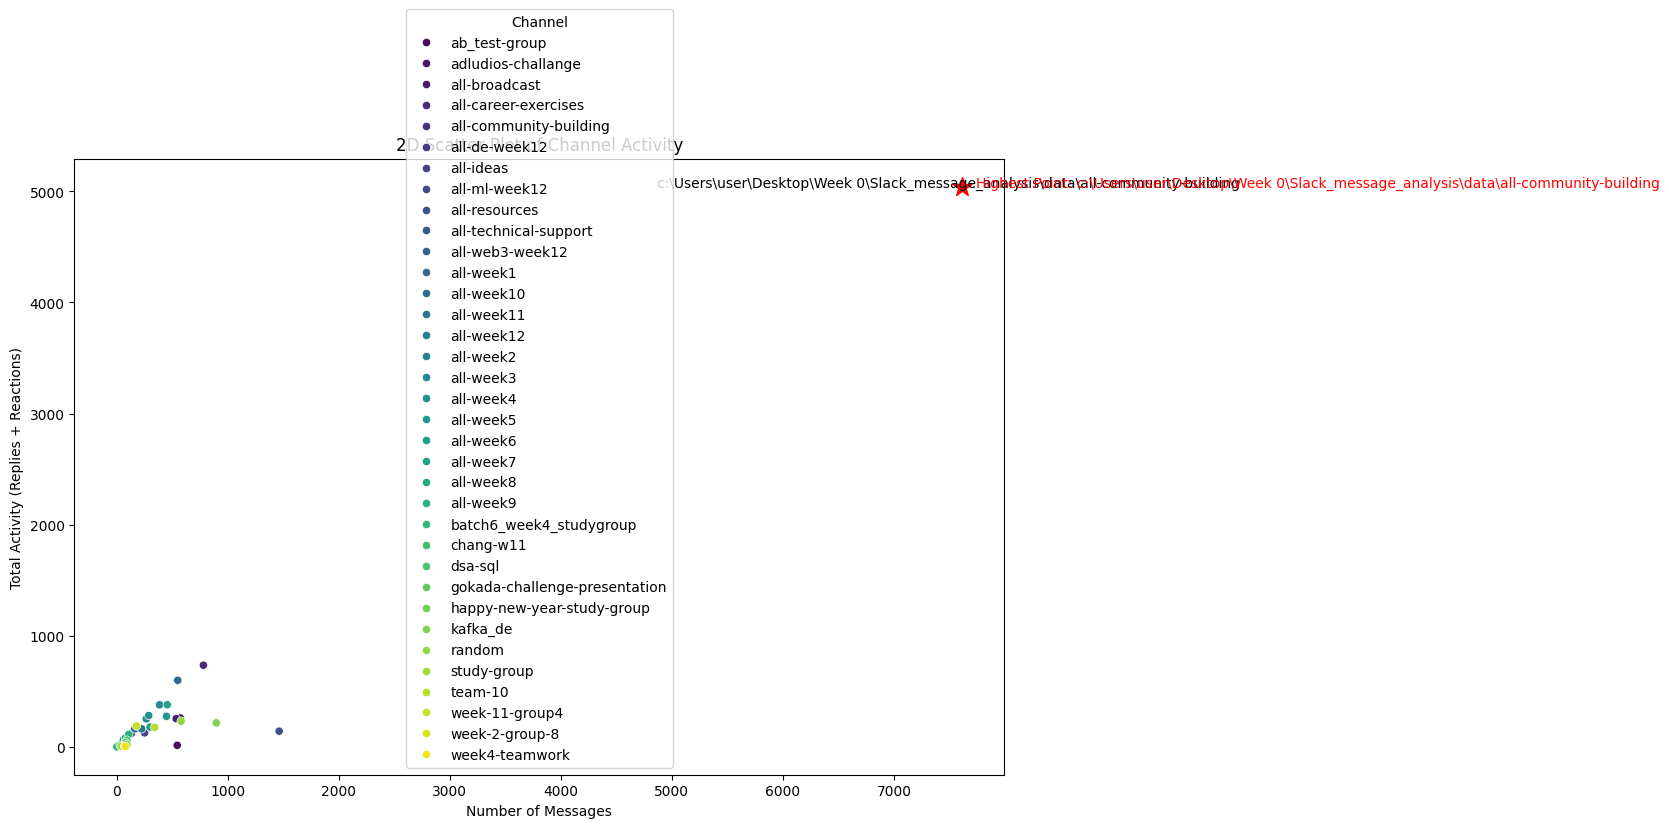

In [88]:


if not slack_parser_df.empty:
    # Calculate the total activity (sum of messages, replies, and reactions) for each channel
    required_columns = ['channel', 'msg_content', 'reply_count', 'reply_users_count']
    missing_columns = [col for col in required_columns if col not in slack_parser_df.columns]

    if missing_columns:
        print(f"Error: The following required columns are missing in the DataFrame: {missing_columns}")
    else:
        # Proceed with the groupby operation
        channel_activity = slack_parser_df.groupby('channel').agg({
            'msg_content': 'count',
            'reply_count': 'sum',
            'reply_users_count': 'sum'
        }).reset_index()

        # Calculate the total activity score (sum of replies and reactions)
        channel_activity['total_activity'] = channel_activity['reply_count'] + channel_activity['reply_users_count']

        if not channel_activity.empty:
            # Find the channel with the highest activity
            most_active_channel = channel_activity.loc[channel_activity['total_activity'].idxmax()]
            print(f"The channel with the highest activity is: {most_active_channel['channel']}")

            # Plot a 2D scatter plot using Matplotlib and Seaborn
            plt.figure(figsize=(12, 8))
            sns.scatterplot(data=channel_activity, x='msg_content', y='total_activity', hue='channel', palette='viridis')

            # Annotate the point at the top right corner
            top_right_channel = channel_activity.loc[channel_activity['msg_content'].idxmax()]
            plt.annotate(f"{top_right_channel['channel']}",
                        (top_right_channel['msg_content'], top_right_channel['total_activity']),
                        textcoords="offset points", xytext=(-10, 0), ha='center')

            # Identify and annotate the highest point
            highest_point = channel_activity.loc[channel_activity['total_activity'].idxmax()]
            plt.scatter(highest_point['msg_content'], highest_point['total_activity'], color='red', marker='*', s=200)
            plt.annotate(f"Highest Point: {highest_point['channel']}",
                         (highest_point['msg_content'], highest_point['total_activity']),
                         textcoords="offset points", xytext=(10, 0), ha='left', color='red', fontsize=10)

            plt.title("2D Scatter Plot of Channel Activity")
            plt.xlabel("Number of Messages")
            plt.ylabel("Total Activity (Replies + Reactions)")

            # Extract legend titles from the legend handles
            legend_handles, legend_labels = plt.gca().get_legend().legendHandles, plt.gca().get_legend().get_texts()
            legend_titles = [os.path.basename(label.get_text()) for label in legend_labels]

            # Update legend
            plt.legend(legend_handles, legend_titles, title='Channel')

            plt.show()
        else:
            print("Error: The channel_activity DataFrame is empty.")
else:
    print("Error: The main DataFrame (df) is empty.")


### 4) What fraction of messages are replied within the first 5mins?

In [120]:
# Step 1: Calculate the Time Difference
slack_parser_df['msg_sent_time'] = utils.convert_2_timestamp('msg_sent_time', slack_parser_df)
slack_parser_df['time_thread_start'] = utils.convert_2_timestamp('time_thread_start', slack_parser_df)
slack_parser_df['tm_thread_end'] = utils.convert_2_timestamp('tm_thread_end', slack_parser_df)

# Debug Print: Check data types after conversion
print("Data Types after Conversion:")
print(slack_parser_df.dtypes)

# Check if 'msg_sent_time' and 'tm_thread_end' are datetimelike
print("msg_sent_time:", pd.api.types.is_datetime64_any_dtype(slack_parser_df['msg_sent_time']))
print("tm_thread_end:", pd.api.types.is_datetime64_any_dtype(slack_parser_df['tm_thread_end']))

# Check for missing values after conversion
print("Missing values after conversion:")
print(slack_parser_df[['msg_sent_time', 'tm_thread_end']].isnull().sum())

# Calculate 'reply_time_diff' before filtering
slack_parser_df['reply_time_diff'] = (slack_parser_df['tm_thread_end'] - slack_parser_df['msg_sent_time']).dt.total_seconds()

# Check for missing values after calculating 'reply_time_diff'
print("Missing values after calculating 'reply_time_diff':")
print(slack_parser_df['reply_time_diff'].isnull().sum())

Data Types after Conversion:
msg_type                                  object
msg_content                               object
sender_name                               object
msg_sent_time                     datetime64[ns]
msg_dist_type                             object
time_thread_start                 datetime64[ns]
reply_count                                int64
reply_users_count                          int64
reply_users                               object
tm_thread_end                     datetime64[ns]
channel                                   object
directory                                 object
time_diff_first_reply            timedelta64[ns]
time_diff_first_reply_minutes            float64
time_of_day                              float64
reply_time_diff                          float64
dtype: object
msg_sent_time: True
tm_thread_end: True
Missing values after conversion:
msg_sent_time    0.0
tm_thread_end    0.0
dtype: float64
Missing values after calculating 'reply_tim

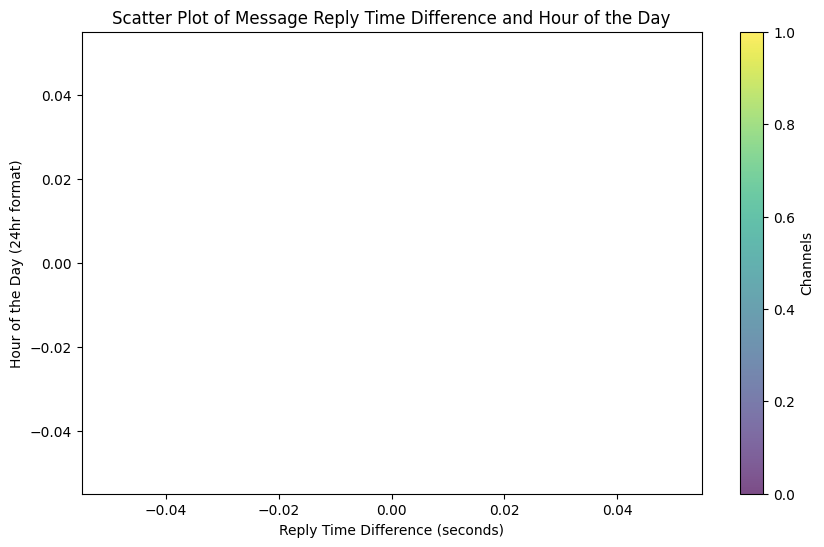

In [121]:
# Step 2: Filter Messages Replied Within the First 5 Minutes
replied_within_5mins = slack_parser_df[slack_parser_df['reply_time_diff'] <= 300]  # 300 seconds = 5 minutes

# Step 3: Extract Hour of the Day
replied_within_5mins['hour_of_day'] = replied_within_5mins['msg_sent_time'].dt.hour

# Step 4: Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    replied_within_5mins['reply_time_diff'],
    replied_within_5mins['hour_of_day'],
    c=replied_within_5mins['channel'].astype('category').cat.codes.values,  # Use values to avoid errors
    cmap='viridis',
    alpha=0.7
)

plt.colorbar(scatter, label='Channels')
plt.title('Scatter Plot of Message Reply Time Difference and Hour of the Day')
plt.xlabel('Reply Time Difference (seconds)')
plt.ylabel('Hour of the Day (24hr format)')
plt.show()

In [ ]:
# Visualize reply counts per user per channel

In [ ]:
# what is the time range of the day that most messages are sent?


In [11]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?